# Modeling

In [1]:
#Import packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib as mpl
import matplotlib.pyplot as plt
from highlight_text import  ax_text, fig_text
import ipywidgets as widgets
from highlight_text import fig_text
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from mplsoccer.pitch import VerticalPitch

#Read data
df = pd.read_csv('shots.csv', encoding='latin-1')
df['X'] = df['X']*120
df['Y'] = df['Y']*80

#calculate distance from goal (centre of goal [120,40])
df['Distance'] = np.sqrt(np.square(120-df['X']) + np.square(40-df['Y']))

# compute the shot angle
x = df['X']
y = df['Y']

def findAngle(a):
    a=np.array(a)
    b=np.array([120,36])
    c=np.array([120,44])
    
    ab = a - b
    ac = a - c
    
    cosine_angle = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
    angle = np.arccos(cosine_angle)
    
    return (angle)

xy=list(zip(x,y))
a=list(map(findAngle,xy))
df["Angle"]=a

In [2]:
#Remove warning
pd.options.mode.chained_assignment = None

#Turn them into dummy variables
df['Corner']= np.where((df['situation'] == 'FromCorner'),1,0)
df['SetPiece']= np.where((df['situation'] == 'SetPiece'),1,0)
df['OpenPlay']= np.where((df['situation'] == 'OpenPlay'),1,0)
df['DirectFreekick']= np.where((df['situation'] == 'DirectFreekick'),1,0)
df['Pen']= np.where((df['situation'] == 'Penalty'),1,0)
df['Header']= np.where((df['shotType'] == 'Head'),1,0)
df['Goal']= np.where((df['result'] == 'Goal'),1,0)

# filling a null values using fillna()
df['player_assisted'].fillna('None', inplace = True)
df['Assisted']= np.where((df['player_assisted'] == 'None'),0,1)

df['Rebound']= np.where((df['lastAction'] == 'Rebound'),1,0)

df['LA_AerialPass']= np.where((df['lastAction'] == 'HeadPass'),1,0)

df['LA_Pass']= np.where(((df['lastAction'] == 'Pass') | 
                         (df['lastAction'] == 'Throughball') | 
                         (df['lastAction'] == 'LayOff') | 
                         (df['lastAction'] == 'Cross') | 
                         (df['lastAction'] == 'Chipped')),1,0)

df['LA_Cross']= np.where((df['lastAction'] == 'Cross'),1,0)
df['LA_Recovery']= np.where((df['lastAction'] == 'BallRecovery'),1,0)
df['LA_Tackle']= np.where((df['lastAction'] == 'Tackle'),1,0)
df['LA_TakeOn']= np.where((df['lastAction'] == 'TakeOn'),1,0)


df['LA_Touch']= np.where((df['lastAction'] == 'BallTouch') & (df['player_assisted'] != 'None'),1,0)

df['LA_OppoTouch']= np.where((df['lastAction'] == 'BallTouch') & (df['player_assisted'] == 'None'),1,0)


#Take in relavant info and arrange them
shots = df[['X','Y','Distance','Angle','Corner','SetPiece','OpenPlay','DirectFreekick',
            'Pen','Header','Assisted','Rebound','LA_Pass','LA_Cross', 'LA_AerialPass',
            'LA_Recovery','LA_Touch','LA_OppoTouch','LA_Tackle','LA_TakeOn','Goal']]

#Rounding
shots['X'] = shots['X'].round(3)
shots['Y'] = shots['Y'].round(3)
shots.head()

,X,Y,Distance,Angle,Corner,SetPiece,OpenPlay,DirectFreekick,Pen,Header,...,Rebound,LA_Pass,LA_Cross,LA_AerialPass,LA_Recovery,LA_Touch,LA_OppoTouch,LA_Tackle,LA_TakeOn,Goal
0,119.88,41.76,1.764087,3.067243,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,119.88,38.56,1.444991,3.072698,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,119.88,30.72,9.280775,0.013687,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,119.88,49.92,9.920727,0.011647,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,119.64,39.12,0.950789,2.953077,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [3]:
shots.loc[(shots['Pen']==1)].head(5)

,X,Y,Distance,Angle,Corner,SetPiece,OpenPlay,DirectFreekick,Pen,Header,...,Rebound,LA_Pass,LA_Cross,LA_AerialPass,LA_Recovery,LA_Touch,LA_OppoTouch,LA_Tackle,LA_TakeOn,Goal
141754,106.2,40.0,13.8,0.564247,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
141755,106.2,40.0,13.8,0.564247,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
141756,106.2,40.0,13.8,0.564247,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
141757,106.2,40.0,13.8,0.564247,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
141758,106.2,40.0,13.8,0.564247,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
print('Total Shots: '+ str(len(shots)))
goals = shots.loc[shots['Goal']==1]
print('Total Goals: '+ str(len(goals)))

Total Shots: 383165
Total Goals: 40134


In [5]:
#Testing
X = shots.iloc[:,:-1].values
y = shots.iloc[:,-1].values

"""
#N_estimators
#Finding how many values of estimators
# grid search
model = XGBClassifier()
n_estimators = range(200, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#max_depth
# grid search
model = XGBClassifier()
max_depth = range(1, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#For both
# grid search
model = XGBClassifier()
n_estimators = [50, 100, 150, 200, 250]
max_depth = [2, 3, 4, 5, 6]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
""";

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

xgb = XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=100)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [7]:
# For each shot, predict the probability of the shot resulting in a goal
pred = xgb.predict_proba(x_test)

In [8]:
#Positive
y_total = np.count_nonzero(y_train >= 0 )
y_positive = np.sum(y_train)

#AUC-ROC
auc_roc = roc_auc_score(y_test, pred[:,1])

#AUC-PR baseline performance
auc_pr_baseline = y_positive / y_total

#AUC-PR
auc_pr = average_precision_score(y_test, pred[:,1])

#Score
score = xgb.score(x_test, y_test)

# xG Boost
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(xgb, x_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))
print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))
print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))
print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))
print('Score: '+str(score))
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

The training set contains 287373 examples of which 30054 are positives.
Our classifier obtains an AUC-ROC of 0.8111778165936276.
The baseline performance for AUC-PR is 0.10458185006942197.
Our classifier obtains an AUC-PR of 0.42793484042705054.
Score: 0.9057750125271421
Accuracy: 0.905 (0.001)


In [9]:
pred2 = xgb.predict_proba(X)
xg = pred2[:,1]
xg = pd.DataFrame({'xg':xg})
xg.head()

,xg
0,0.944301
1,0.985511
2,0.009390
3,0.010722
4,0.987639


In [10]:
shots['Original_xG'] = df['xG']
shots['Model_xG'] = xg
#shots.head(20)
#shots.loc[(shots['Pen']==1)].head(5)

# Implementation with Opta Data

In [11]:
#Import new data
df2 = pd.read_csv('Footballdata/New/BrentfordvsManUtd.csv', encoding='latin-1')

#Adjust to pitch size
df2['x'] = df2['x']*1.2
df2['y'] = df2['y']*.8
df2['endX'] = df2['endX']*1.2
df2['endY'] = df2['endY']*.8

#remove substitution events,challenges & formation change
df2 = df2.loc[~(df2['type/displayName'] == 'SubstitutionOff')]
df2 = df2.loc[~(df2['type/displayName'] == 'SubstitutionOn')]
df2 = df2.loc[~(df2['type/displayName'] == 'FormationChange')]
df2 = df2.loc[~(df2['type/displayName'] == 'Challenge')]

#remove the records of a failed aerial, they should be ignored as their challenges are failed and the shot continues
df2 = df2.loc[~((df2['type/displayName'] == 'Aerial') & (df2['outcomeType/displayName'] == 'Unsuccessful'))]

#Finding previous team
df2['prevteam'] = df2['teamId'].shift(1)

#Finding previous event
df2['prevevent'] = df2['type/displayName'].shift(1)

#Finding next event
df2['nextevent'] = df2['type/displayName'].shift(-1)

#finding the previous event that occured along with the x & y positions
df2['prev_x'] = df2['x'].shift(1)
df2['prev_y'] = df2['y'].shift(1)

#finding the previous event that occured along with the y positions (for crosses that end up as headers)
df2['prev2_y'] = df2['y'].shift(2)
df2['prev2event'] = df2['type/displayName'].shift(2)

df2.head()

,id,eventId,minute,second,teamId,x,y,expandedMinute,period/value,period/displayName,...,goalMouthY,isShot,isGoal,prevteam,prevevent,nextevent,prev_x,prev_y,prev2_y,prev2event
0,2445490703,2,0,0.0,Brentford,0.00,0.00,0,1,FirstHalf,...,NaN,NaN,NaN,NaN,NaN,Start,NaN,NaN,NaN,NaN
1,2445490699,2,0,0.0,Manchester United,0.00,0.00,0,1,FirstHalf,...,NaN,NaN,NaN,Brentford,Start,Pass,0.00,0.00,NaN,NaN
2,2445490731,3,0,0.0,Manchester United,60.00,40.00,0,1,FirstHalf,...,NaN,NaN,NaN,Manchester United,Start,Pass,0.00,0.00,0.0,Start
3,2445490755,4,0,3.0,Manchester United,50.16,27.76,0,1,FirstHalf,...,NaN,NaN,NaN,Manchester United,Pass,Pass,60.00,40.00,0.0,Start
4,2445490781,5,0,6.0,Manchester United,36.48,26.32,0,1,FirstHalf,...,NaN,NaN,NaN,Manchester United,Pass,Pass,50.16,27.76,40.0,Pass


In [12]:
#Data transformation
df2['Goal'] = np.where((df2['isGoal'] == True),1,0)

df2['Header'] = np.where((df2['isShot'] == True) & 
                         (df2['prevevent'] == 'Aerial'),1,0)

#Common for penalties is PenaltyFaced, either before or after column
df2['Pen'] = np.where((df2['isShot'] == True) & 
                     ((df2['prevevent'] == 'PenaltyFaced') | 
                      (df2['nextevent'] == 'PenaltyFaced')),1,0)

#Model does not include indirect freekicks, will be assigned as openplay; excludes Penalties because both share common events
df2['DirectFreeKick'] = np.where((df2['isShot'] == True) & 
                                 (df2['Pen'] == 0) &
                                ((df2['prevevent'] == 'Foul') | (df2['prevevent'] == 'Card')),1,0) 

df2['Corner'] = np.where((df2['isShot'] == True) &
                         (df2['Pen'] == 0) &
                         (df2['DirectFreeKick'] == 0) &
                        ((df2['type/displayName'].shift(7).eq('CornerAwarded')) | 
                         (df2['type/displayName'].shift(6).eq('CornerAwarded')) | 
                         (df2['type/displayName'].shift(5).eq('CornerAwarded')) | 
                         (df2['type/displayName'].shift(4).eq('CornerAwarded')) | 
                         (df2['type/displayName'].shift(3).eq('CornerAwarded'))),1,0)
            
df2['SetPiece'] = np.where((df2['isShot'] == True) &
                           (df2['Pen'] == 0) & #Exclude Penalties
                           (df2['Corner'] == 0) & #Exclude Penalties
                           (df2['DirectFreeKick'] == 0) & #Exclude DirectFK
                          ((df2['type/displayName'].shift(9).eq('Foul')) | 
                           (df2['type/displayName'].shift(8).eq('Foul')) | 
                           (df2['type/displayName'].shift(7).eq('Foul')) | 
                           (df2['type/displayName'].shift(6).eq('Foul')) |
                           (df2['type/displayName'].shift(5).eq('Foul')) |
                           (df2['type/displayName'].shift(4).eq('Foul')) |
                           (df2['type/displayName'].shift(3).eq('Foul'))),1,0)

df2['OpenPlay'] = np.where((df2['isShot'] == True) &
                           (df2['Pen'] == 0) & 
                           (df2['DirectFreeKick'] == 0) & 
                           (df2['Corner'] == 0) & 
                           (df2['SetPiece'] == 0),1,0)

df2['Assisted'] = np.where((df2['isShot'] == True) & 
                           (df2['Pen'] == 0) &
                           (df2['DirectFreeKick'] == 0) &
                          ((df2['prevteam'] == df2['teamId'])),1,0)

df2['Rebound'] = np.where((df2['isShot'] == True) & 
                           (df2['Pen'] == 0) &
                           (df2['DirectFreeKick'] == 0) &
                          ((df2['prevevent'] == 'Save') |
                           (df2['prevevent'] == 'ShotOnPost')),1,0)
                           
df2['LA_Pass'] = np.where((df2['isShot'] == True) & 
                          (df2['prevevent'] == 'Pass'),1,0)

df2['LA_Recovery'] = np.where((df2['isShot'] == True) & 
                              ((df2['prevevent'] == 'BallRecovery') |
                               (df2['prevevent'] == 'Interception') |
                               (df2['prevevent'] == 'BlockedPass')),1,0)

df2['LA_Tackle'] = np.where((df2['isShot'] == True) & 
                            (df2['prevevent'] == 'Tackle'),1,0)

df2['LA_TakeOn'] = np.where((df2['isShot'] == True) & 
                            (df2['prevevent'] == 'TakeOn'),1,0)

df2['LA_Touch'] = np.where((df2['isShot'] == True) & 
                            (df2['prevevent'] == 'BallTouch') &
                            (df2['prevteam'] == df2['teamId']) ,1,0)

df2['LA_OppoTouch'] = np.where((df2['isShot'] == True) & 
                            (df2['prevevent'] == 'BallTouch') &
                            (df2['prevteam'] != df2['teamId']) ,1,0)

df2['LA_AerialPass'] = np.where((df2['isShot'] == True) & 
                            (df2['prevevent'] == 'Pass') &
                            (df2['prevteam'] == df2['teamId']) &
                            (df2['prev2event'] == 'Aerial'),1,0)

df2['LA_Cross'] = np.where((df2['isShot'] == True) & 
                            (df2['LA_AerialPass'] == 0) &
                            (df2['x'] > 100 ) &
                           
                           ((df2['prev_y'] < 17.5) |
                            (df2['prev_y'] > 62.5) |
                            (df2['prev2_y'] > 62.5) |
                            (df2['prev2_y'] < 17.5)) &
                           
                           ((df2['prev2event'] == 'Pass') |
                            (df2['prevevent'] == 'Pass')),1,0)


#df2.loc[(df2['OpenPlay'] == 1)]

In [13]:
#calculate distance from goal (centre of goal [120,40])
df2['Distance'] = np.sqrt(np.square(120-df2['x']) + np.square(40-df2['y']))

# compute the shot angle
x = df2['x']
y = df2['y']

def findAngle(a):
    a=np.array(a)
    b=np.array([120,36])
    c=np.array([120,44])
    
    ab = a - b
    ac = a - c
    
    cosine_angle = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
    angle = np.arccos(cosine_angle)
    
    return (angle)

xy=list(zip(x,y))
a=list(map(findAngle,xy))
df2["Angle"]=a

In [14]:
df2 = df2.loc[df2['isShot']==True]

#Take in relavant info and arrange them
df3 = df2[['x','y','Distance','Angle','Corner','SetPiece','OpenPlay','DirectFreeKick','Pen','Header',
           'Assisted','Rebound','LA_Pass','LA_Cross','LA_AerialPass',
           'LA_Recovery','LA_Touch','LA_OppoTouch','LA_Tackle','LA_TakeOn','Goal']] 

#Rename
df3.rename(columns = {'x':'X', 'y':'Y','DirectFreeKick':'DirectFreekick'}, inplace = True)

In [15]:
p = df3.iloc[:,:-1].values
prediction = xgb.predict_proba(p)
xG = prediction[:,-1]
xG
df3['xG'] = xG

In [16]:
#concatenate to obtain the name and other details
shotsdf = pd.concat([df2, df3], axis=1)
shotsdf['Kit Number'] = shotsdf['Kit Number'].astype(int)
shotsdf = shotsdf[['id','expandedMinute','period/displayName','teamId','playername','Kit Number',
                   'x','y', 'type/displayName','Distance','Angle','Corner',
                   'SetPiece','OpenPlay','DirectFreeKick','Pen','Header','Assisted','Rebound','LA_OppoTouch',
                   'LA_Pass','LA_Cross','LA_AerialPass','LA_Recovery','LA_Touch','LA_Tackle','LA_TakeOn','Goal','xG']]

#shotsdf = shotsdf.loc[:,~shotsdf.columns.duplicated()]

In [17]:
xgflowchart = shotsdf[['expandedMinute','teamId','xG','playername','type/displayName']]
xgflowchart.rename(columns = {'teamId':'team', 'playername':'player','type/displayName':'result'}, inplace = True)
xgflowchart = xgflowchart.reset_index(drop=True)
xgflowchart['Goal'] = np.where((xgflowchart['result'] == 'Goal'),1,0)
xgflowchart.head(10)

,expandedMinute,team,xG,player,result,Goal
0,3,Manchester United,0.010833,Cristiano Ronaldo,SavedShot,0
1,5,Brentford,0.022731,Rico Henry,MissedShots,0
2,9,Brentford,0.020099,Josh Dasilva,Goal,1
3,10,Manchester United,0.097655,Bruno Fernandes,MissedShots,0
4,13,Brentford,0.028065,Bryan Mbeumo,SavedShot,0
5,16,Brentford,0.094439,Mathias Jensen,MissedShots,0
6,17,Brentford,0.361858,Mathias Jensen,Goal,1
7,19,Manchester United,0.039400,Cristiano Ronaldo,MissedShots,0
8,23,Manchester United,0.025122,Marcus Rashford,SavedShot,0
9,23,Manchester United,0.056532,Diogo Dalot,SavedShot,0


In [18]:
#Identify teams
t = []
for i in xgflowchart.team.unique():
    t.append(i)

hteam = t[0]
ateam = t[1]

#total goals
goal_h = xgflowchart.loc[(xgflowchart['team'] == hteam) & xgflowchart['Goal'] == 1]
goal_h = len(goal_h)

goal_a = xgflowchart.loc[(xgflowchart['team'] == ateam) & xgflowchart['Goal'] == 1]
goal_a = len(goal_a)

#4 lists - home and away xg and minutes; start with zero so charts will start at 0
a_xG = [0]
h_xG= [0]
a_min = [0]
h_min = [0]

# for loop to obtain xG from df
for x in range(len(xgflowchart['xG'])):
    
    if xgflowchart['team'][x]==ateam:
        a_xG.append(xgflowchart['xG'][x])
        a_min.append(xgflowchart['expandedMinute'][x])
        
    if xgflowchart['team'][x]==hteam:
        h_xG.append(xgflowchart['xG'][x])
        h_min.append(xgflowchart['expandedMinute'][x])

#this is the function we use to make our xG values be cumulative rather than single shot values
#it goes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

#this is used to find the total xG. It just creates a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

In [19]:
#Process of obtaining goal values
#Home
#assign the cumulative values to the dataframe filtered for teams
h_xgflowchart = xgflowchart.loc[xgflowchart['team']==hteam]
h_cumulative1 = h_cumulative[1:]
h_xgflowchart['Cumulative'] = h_cumulative1
h_xgflowchart = h_xgflowchart.loc[h_xgflowchart['Goal']==1]
h_xgflowchart = h_xgflowchart[['expandedMinute','Cumulative']].reset_index(drop=True)

a_xgflowchart = xgflowchart.loc[xgflowchart['team']==ateam]
a_cumulative1 = a_cumulative[1:]
a_xgflowchart['Cumulative'] = a_cumulative1
a_xgflowchart = a_xgflowchart.loc[a_xgflowchart['Goal']==1]
a_xgflowchart = a_xgflowchart[['expandedMinute','Cumulative']].reset_index(drop=True)

#plot shots
homeshotplot = xgflowchart[(xgflowchart['team'] == hteam)]['expandedMinute'].reset_index(drop = True)
awayshotplot = xgflowchart[(xgflowchart['team'] == ateam)]['expandedMinute'].reset_index(drop = True)

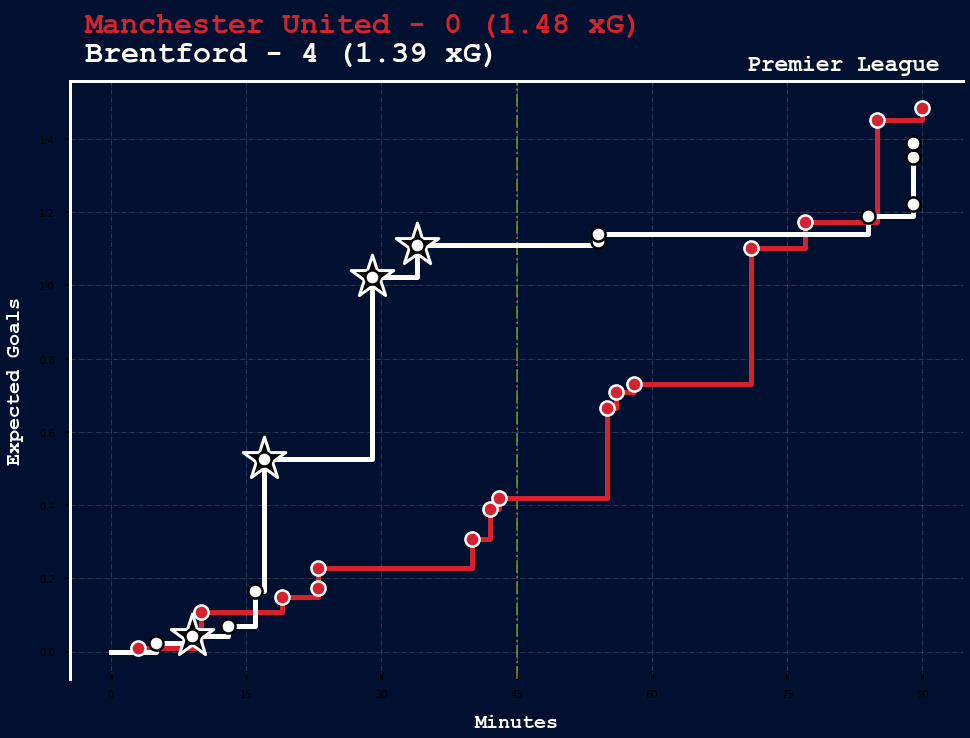

In [20]:
#Set color
homecolor = '#d6222f'
awaycolor = 'white'

#make the plot
fig, ax = plt.subplots(figsize=(16,11))
fig.set_facecolor('#001031')
mpl.rcParams['figure.dpi'] = 400

#background color
ax.patch.set_facecolor('#001031')

#set up our base layer
mpl.rcParams['xtick.color'] = 'yellow'
mpl.rcParams['ytick.color'] = 'yellow'

#setting up the grid
ax.grid(ls='-.', lw=0.8, color='white', axis='y', zorder=0, alpha=0.2)
ax.grid(ls='-.', lw=0.8, color='white', axis='x', zorder=0, alpha=0.2)

#Setting up the spine
spines = ['right','bottom']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
        
#Set spine width & color
ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('w')

#set the ticks
ax.set_xticks([0,15,30,45,60,75,90])

#Set halfway-line
ax.axvline(45, c='yellow', alpha=0.4, ls='-.', lw=2)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=10, width=3,length=5,direction='in')
ax.yaxis.set_tick_params(pad=10, width=2,length=5)

ax.set_ylabel('Expected Goals',fontname='Courier New',color='white',fontsize=20, fontweight = 'bold', labelpad = 15)
ax.set_xlabel('Minutes',fontname='Courier New',color='white',fontsize=20, fontweight = 'bold', labelpad = 15)

#plot goals
#home
ax.scatter(x=h_xgflowchart['expandedMinute'], y=h_xgflowchart['Cumulative'],
           marker='*',s=2000, color='w', zorder=3, edgecolors=homecolor, linewidths=3)

#away
ax.scatter(x=a_xgflowchart['expandedMinute'], y=a_xgflowchart['Cumulative'],
           marker='*',s=2000, color='black', zorder=3, edgecolors=awaycolor, linewidths=3)
 
#Setting Plot fonts
font = {'family' : 'Courier New',
        'weight' : 'bold',
        'size' : 18}
mpl.rc('font', **font)

#plot the step graphs
ax.step(x=h_min,y=h_cumulative,color=homecolor,label=hteam,linewidth=5,where='post')
ax.step(x=a_min,y=a_cumulative,color=awaycolor,label=ateam,linewidth=5,where='post')

#set title
highlight_textprops =\
    [{"color": homecolor,"fontweight": 'bold'},
     {"color": awaycolor,"fontweight": 'bold'}
    ]

Title = fig_text(s = f"<{hteam} - {goal_h} ({hlast} xG)>\n<{ateam} - {goal_a} ({alast} xG)>",
        x = 0.38, y = 0.965, color='white',highlight_textprops = highlight_textprops,
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30)

fig.text(0.88, 0.9,'Premier League', fontsize=23, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

"""fig.text(0.3, 0.05, 'Model By: @chunhang7', fontsize=17, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

fig.text(0.9, 0.05,'Credit: @myusufraihan', fontsize=17, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')"""

#plot shots
ax.scatter(homeshotplot, h_cumulative1, marker = "o", s=200, 
           color=homecolor, zorder=3, edgecolors='w', linewidths=2.5)

ax.scatter(awayshotplot, a_cumulative1, marker = "o", s=200, 
           color=awaycolor, zorder=3, edgecolors='black', linewidths=2.5)

plt.show()

# Shots Map 

In [21]:
#Filter for the shotsmap, need x and y locations
shotmap = shotsdf[['teamId','playername','Kit Number','x','y','type/displayName','xG']]
shotmap.rename(columns = {'teamId':'team', 'playername':'player','type/displayName':'result'}, inplace = True)

#Combo box, choose team
options = shotmap["team"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Manchester United', 'Brentford'), placeh…

In [22]:
team = teamlist.value

#Filter for team shots
shotmapdf = shotmap.loc[(shotmap['team']== team)]
shotmapdf['xG'] = shotmapdf['xG'].astype('float64')
shotmapdf['xG'] = shotmapdf['xG']*7500

#Filter for the events
SoT = shotmapdf.loc[(shotmapdf['result']== "SavedShot") | (shotmapdf['result']== "ShotOnPost")]
Miss = shotmapdf.loc[shotmapdf['result']== "MissedShots"]
Goal = shotmapdf.loc[shotmapdf['result']== "Goal"]

#Retrieve Opposition team
oppo = shotmap.loc[(shotmap['team']!= team)]
oppo = oppo['team'].unique()
oppo = oppo[0]

#List for annotation of numbers
num = shotmapdf[['player','Kit Number','x','y']].reset_index(drop=True)
num.rename(columns = {'Kit Number':'Num'},inplace = True)
num['Num'] = num['Num'].astype(int)
num.index += 1

#Count number of shots
totalshots = num.x.count()
totalshots=str(totalshots)

#Total xG
totalxg = shotmapdf.xG.sum() / 7500
totalxg = round(totalxg,2)
totalxg = str(totalxg)

#total goals
goalsnumdf = shotmapdf.loc[shotmapdf['result'] == 'Goal']
goalsnum = goalsnumdf.result.count()
goalsnum = str(goalsnum)

#List for annotation of numbers
num = goalsnumdf[['player','Kit Number','x','y']].reset_index(drop=True)
num.rename(columns = {'Kit Number':'Num'},inplace = True)
num['Num'] = num['Num'].astype(int)
num.index += 1

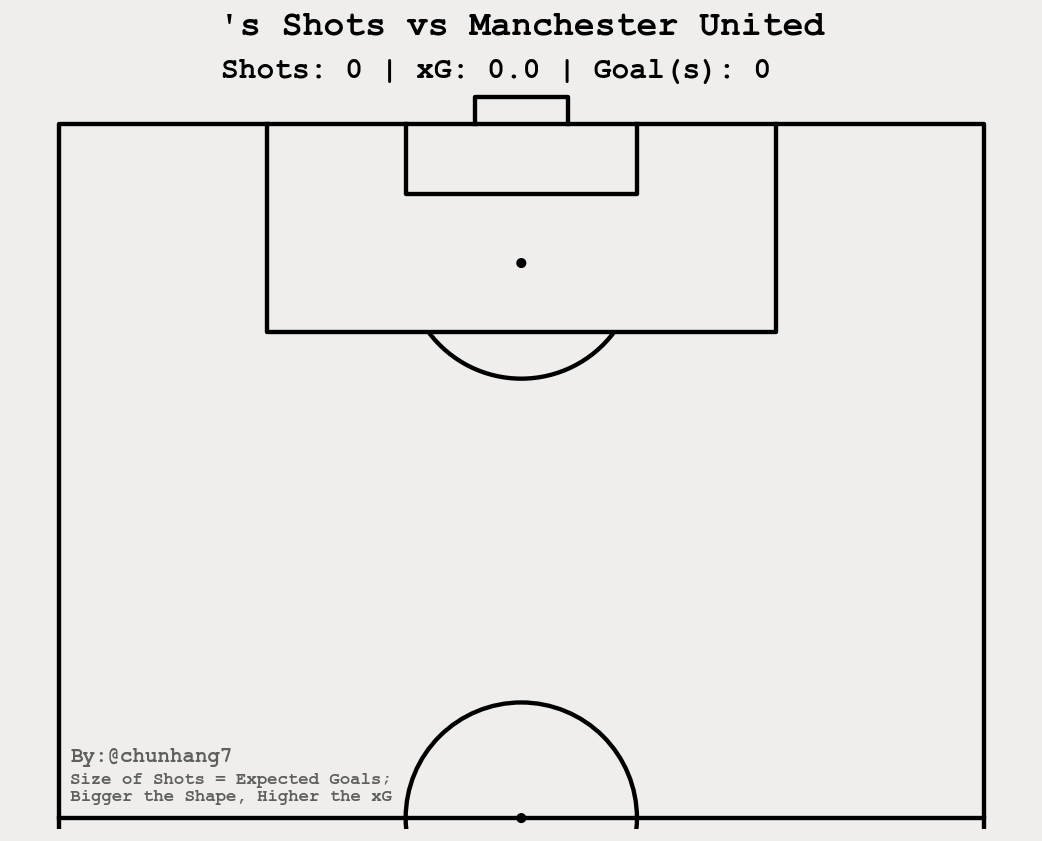

In [23]:
pitch = VerticalPitch(pad_bottom=0.9,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      pitch_type='statsbomb', 
                      pitch_color='#efeeec', 
                      line_color='black',
                      linewidth=2.5, 
                      spot_scale=0.003)

mpl.rcParams['figure.dpi'] = 125
fig, ax = pitch.draw(figsize=(9,7))
fig.set_facecolor('#efeeec')

plt.gca().invert_xaxis()

#plot the shot locations

#Goals
pitch.scatter(Goal.x, Goal.y, s= Goal.xG, c='yellow', edgecolors='black', 
              zorder=3, linewidth = 1.75, marker='*', ax=ax, label = ' Goal')
#Shots on Target
pitch.scatter(SoT.x, SoT.y, s= SoT.xG , c='lightgreen', edgecolors='black', alpha= 0.7,
              zorder=2, linewidth = 0, marker='o', ax=ax, label = ' Shot on Target')
#Miss
pitch.scatter(Miss.x, Miss.y, s= Miss.xG, c='#b94b75', edgecolors='black', alpha= 0.6,
              zorder=1, linewidth = 0, marker='o', ax=ax, label = ' Missed Shot')

plt.title(team+"'s Shots vs "+oppo+'\n',color='black',size=20, fontfamily = "Courier New", fontweight = "bold")

ax.text(66,124, 'Shots: ' + totalshots +' | xG: ' + totalxg +' | Goal(s): ' + goalsnum, fontsize=17, 
        color='black',fontweight = "bold",fontfamily = "Courier New")

#Kit Numbers on Nodes
for index, row in num.iterrows():
    pitch.annotate(row.Num, xy=(row.x,row.y), c='black', va='center', ha='center', 
                   size=9.5, fontweight='bold', fontfamily="Courier New",ax=ax)

#credits
fig.text(0.385,.07,'Size of Shots = Expected Goals;\n Bigger the Shape, Higher the xG', alpha=0.6,
         fontsize=10,fontfamily='Courier New',ha='right',color='black',fontweight='bold')
    
#credits
fig.text(.244,.115,'By:@chunhang7',fontsize=12,fontfamily='Courier New',alpha=0.6,
       ha='right',color='black',fontweight='bold')

plt.show()

# Using Self-Made Data

In [24]:
df2 = pd.read_csv('Msia.csv')

#Adjust to pitch size
df2['X'] = df2['X']*1.2
df2['Y'] = df2['Y']*.8

#df2.head()

In [25]:
#calculate distance from goal (centre of goal [120,40])
df2['Distance'] = np.sqrt(np.square(120-df2['X']) + np.square(40-df2['Y']))

# compute the shot angle
x = df2['X']
y = df2['Y']

def findAngle(a):
    a=np.array(a)
    b=np.array([120,36])
    c=np.array([120,44])
    
    ab = a - b
    ac = a - c
    
    cosine_angle = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
    angle = np.arccos(cosine_angle)
    
    return (angle)

xy=list(zip(x,y))
a=list(map(findAngle,xy))
df2["Angle"]=a

In [26]:
#Take in relavant info and arrange them
df3 = df2[['X','Y','Distance','Angle','Corner','SetPiece','OpenPlay','DirectFreeKick','Pen','Header',
           'Assisted','Rebound','LA_Pass','LA_Cross','LA_AerialPass','LA_Recovery','LA_Touch', 'LA_OppoTouch',
           'LA_Tackle','LA_TakeOn','Goal']]

p = df3.iloc[:,:-1].values
prediction = xgb.predict_proba(p)
xG = prediction[:,-1]
df3['xG'] = xG

df3['expandedMinute'] = df2['expandedMinute']
df3['Team'] = df2['Team']

xgflowchart = df3[['expandedMinute','Team','xG','Goal']]
xgflowchart.head(10)

,expandedMinute,Team,xG,Goal
0,2,Sogdiana,0.023800,0
1,3,Sogdiana,0.102948,0
2,11,Sogdiana,0.006451,0
3,19,Sogdiana,0.005444,0
4,20,Sogdiana,0.016838,0
5,22,Sogdiana,0.018458,0
6,23,Sogdiana,0.034513,0
7,24,Kuala Lumpur City Fc,0.015473,0
8,26,Sogdiana,0.050494,0
9,28,Kuala Lumpur City Fc,0.029141,0


In [27]:
#Identify teams
t = []
for i in xgflowchart.Team.unique():
    t.append(i)

hteam = t[0]
ateam = t[1]

#total goals
goal_h = xgflowchart.loc[(xgflowchart['Team'] == hteam) & xgflowchart['Goal'] == 1]
goal_h = len(goal_h)

goal_a = xgflowchart.loc[(xgflowchart['Team'] == ateam) & xgflowchart['Goal'] == 1]
goal_a = len(goal_a)

#4 lists - home and away xg and minutes; start with zero so charts will start at 0
a_xG = [0]
h_xG= [0]
a_min = [0]
h_min = [0]

# for loop to obtain xG from df
for x in range(len(xgflowchart['xG'])):
    
    if xgflowchart['Team'][x]==ateam:
        a_xG.append(xgflowchart['xG'][x])
        a_min.append(xgflowchart['expandedMinute'][x])
        
    if xgflowchart['Team'][x]==hteam:
        h_xG.append(xgflowchart['xG'][x])
        h_min.append(xgflowchart['expandedMinute'][x])

#this is the function we use to make our xG values be cumulative rather than single shot values
#it goes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

#this is used to find the total xG. It just creates a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

In [28]:
#Process of obtaining goal values
#Home
#assign the cumulative values to the dataframe filtered for teams
h_xgflowchart = xgflowchart.loc[xgflowchart['Team']==hteam]
h_cumulative1 = h_cumulative[1:]
h_xgflowchart['Cumulative'] = h_cumulative1
h_xgflowchart = h_xgflowchart.loc[h_xgflowchart['Goal']==1]
h_xgflowchart = h_xgflowchart[['expandedMinute','Cumulative']].reset_index(drop=True)

a_xgflowchart = xgflowchart.loc[xgflowchart['Team']==ateam]
a_cumulative1 = a_cumulative[1:]
a_xgflowchart['Cumulative'] = a_cumulative1
a_xgflowchart = a_xgflowchart.loc[a_xgflowchart['Goal']==1]
a_xgflowchart = a_xgflowchart[['expandedMinute','Cumulative']].reset_index(drop=True)

#plot shots
homeshotplot = xgflowchart[(xgflowchart['Team'] == hteam)]['expandedMinute'].reset_index(drop = True)
awayshotplot = xgflowchart[(xgflowchart['Team'] == ateam)]['expandedMinute'].reset_index(drop = True)

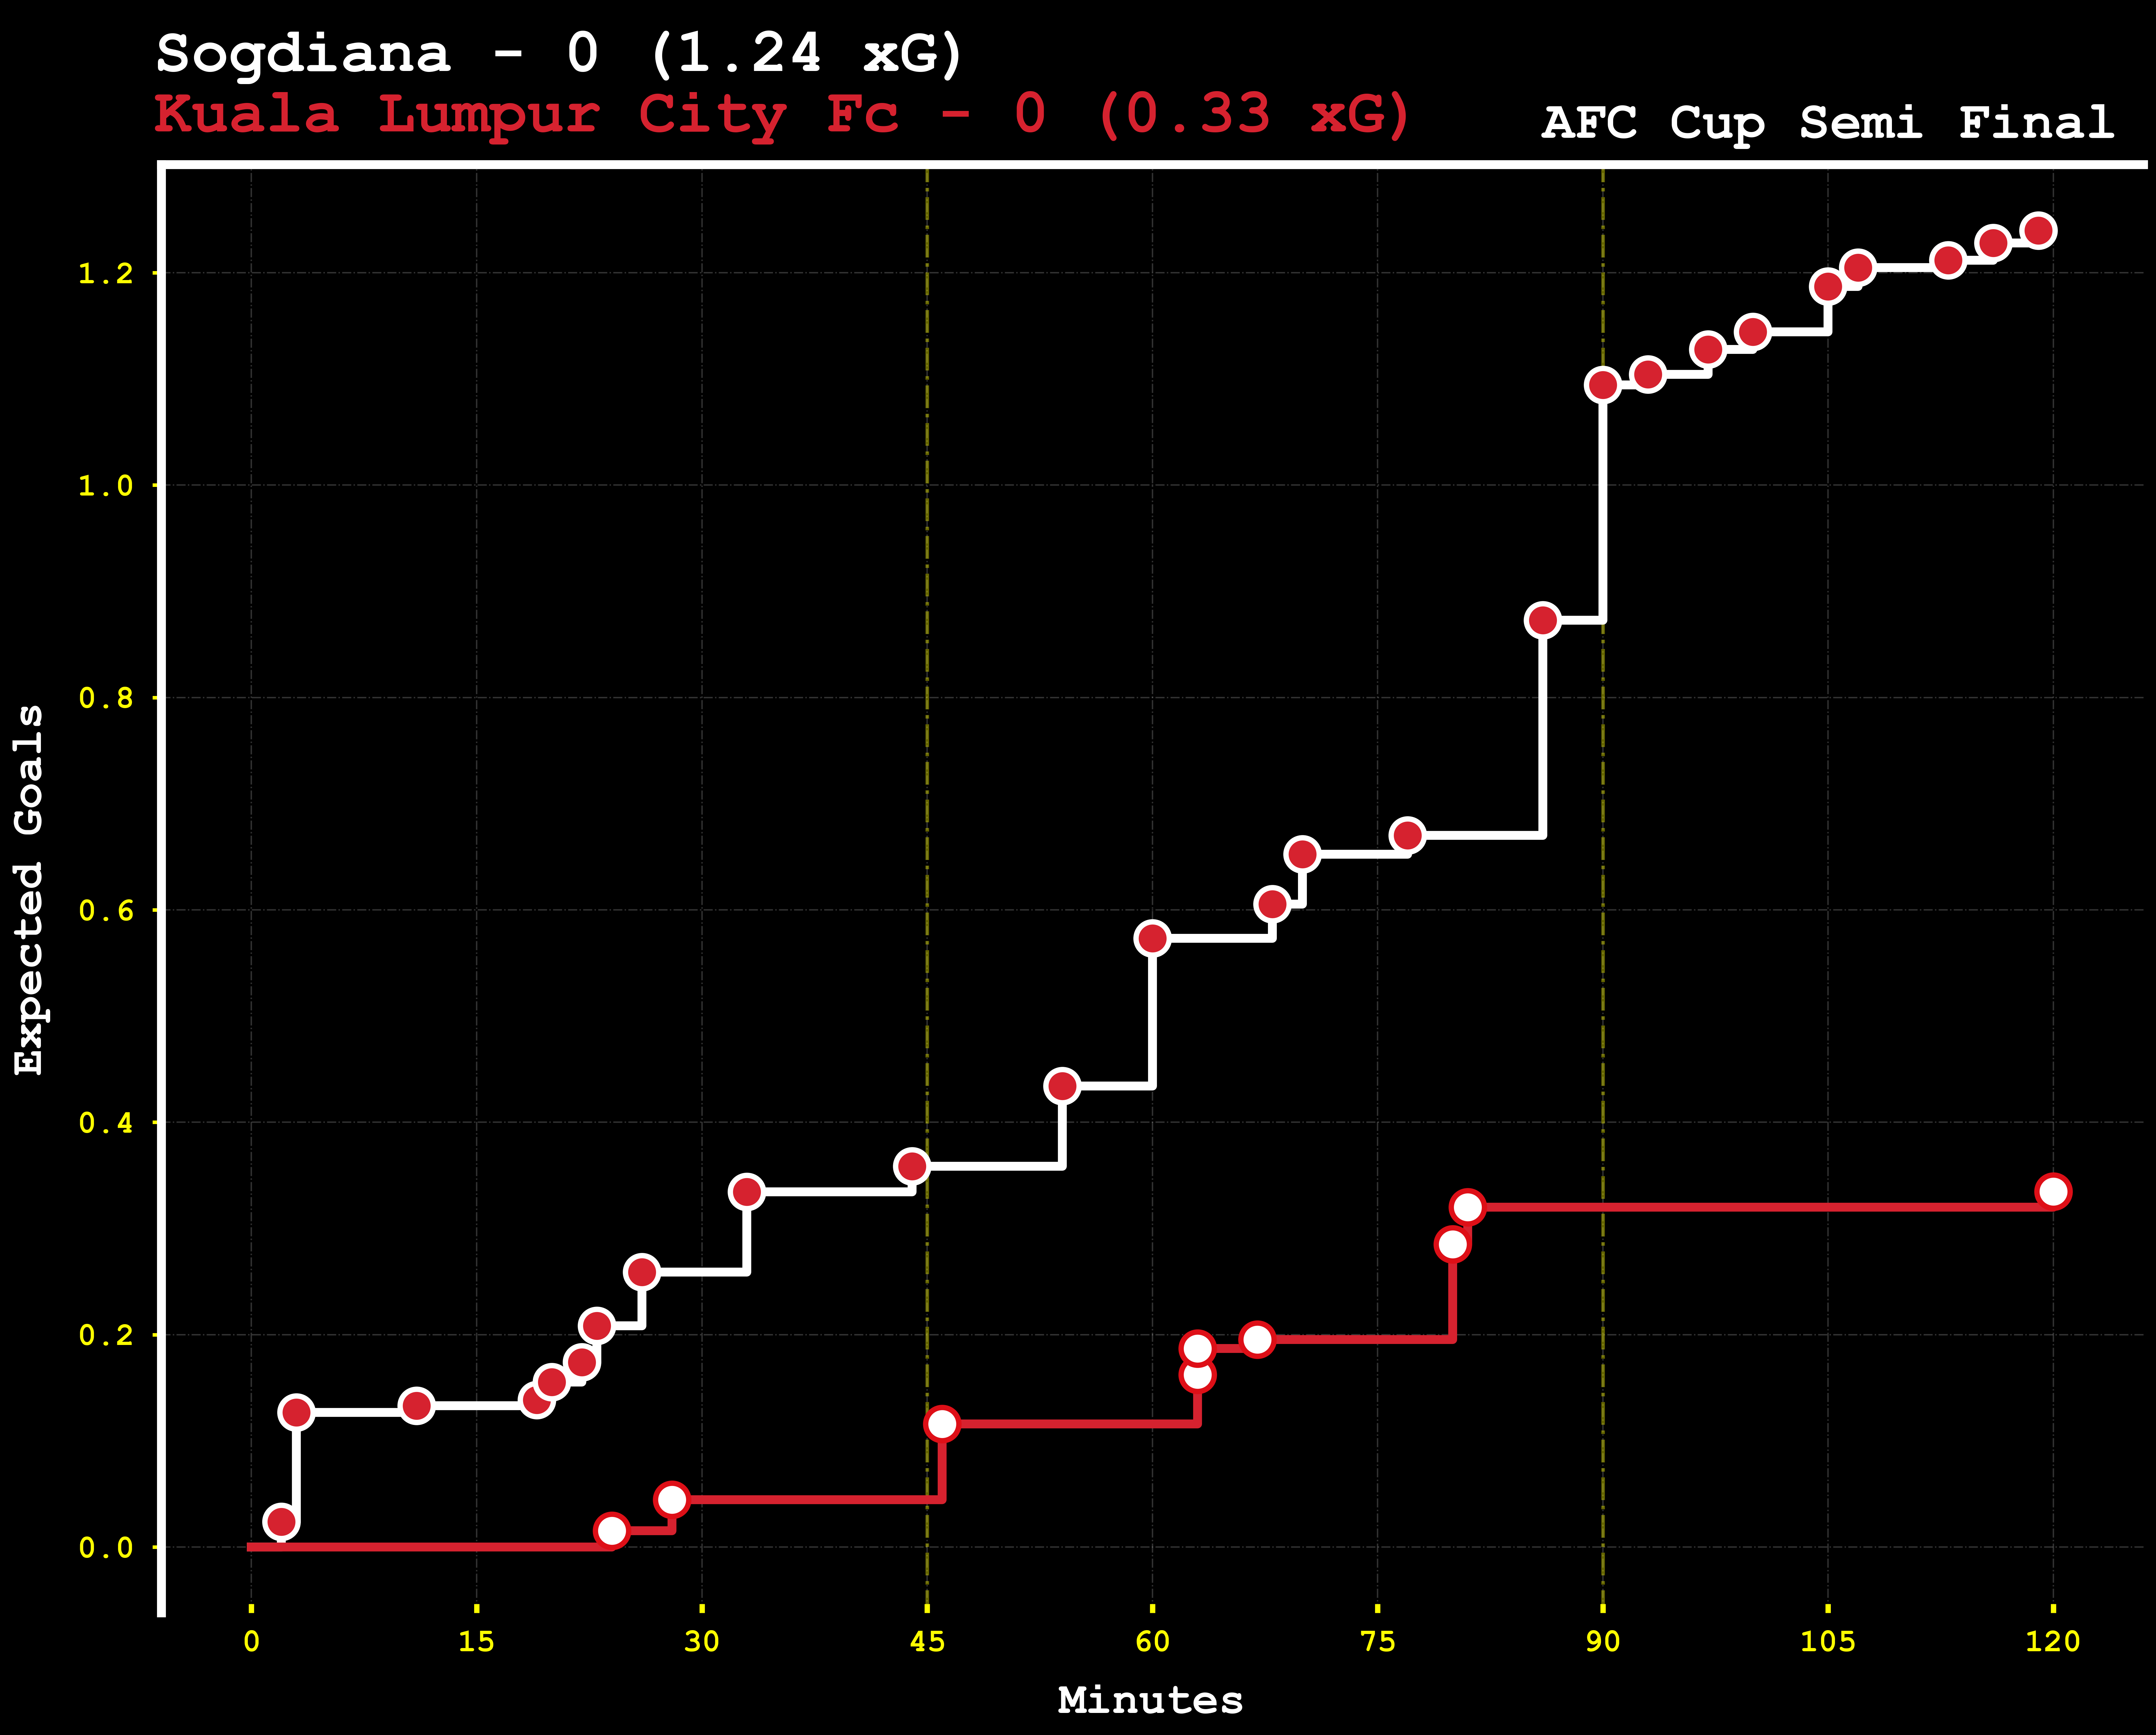

In [44]:
#Set color
homecolor = 'w'
awaycolor = '#d6222f'

#make the plot
fig, ax = plt.subplots(figsize=(20,15))
fig.set_facecolor('black')
mpl.rcParams['figure.dpi'] = 400

#background color
ax.patch.set_facecolor('black')

#set up our base layer
mpl.rcParams['xtick.color'] = 'yellow'
mpl.rcParams['ytick.color'] = 'yellow'

#setting up the grid
ax.grid(ls='-.', lw=0.8, color='white', axis='y', zorder=0, alpha=0.2)
ax.grid(ls='-.', lw=0.8, color='white', axis='x', zorder=0, alpha=0.2)

#Setting up the spine
spines = ['right','bottom']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
        
#Set spine width & color
ax.spines['left'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('w')

#set the ticks
ax.set_xticks([0,15,30,45,60,75,90,105,120])

#Set halfway-line
ax.axvline(45, c='yellow', alpha=0.4, ls='-.', lw=2)

#Set halfway-line
ax.axvline(90, c='yellow', alpha=0.4, ls='-.', lw=2)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=10, width=3,length=5,direction='in')
ax.yaxis.set_tick_params(pad=10, width=2,length=5)

ax.set_ylabel('Expected Goals',fontname='Courier New',color='white',fontsize=25, fontweight = 'bold', labelpad = 15)
ax.set_xlabel('Minutes',fontname='Courier New',color='white',fontsize=25, fontweight = 'bold', labelpad = 15)

#plot goals
#home
ax.scatter(x=h_xgflowchart['expandedMinute'], y=h_xgflowchart['Cumulative'],
           marker='*',s=2500, color=homecolor, zorder=3, edgecolors=awaycolor, linewidths=2)

#away
ax.scatter(x=a_xgflowchart['expandedMinute'], y=a_xgflowchart['Cumulative'],
           marker='*',s=2000, color='w', zorder=3, edgecolors=homecolor, linewidths=3)
 
#Setting Plot fonts
font = {'family' : 'Courier New',
        'weight' : 'bold',
        'size' : 25}
mpl.rc('font', **font)

#plot the step graphs
ax.step(x=h_min, y=h_cumulative, color=homecolor, label=hteam, linewidth=5,where='post')
ax.step(x=a_min, y=a_cumulative, color=awaycolor, label=ateam, linewidth=5,where='post')

#set title
highlight_textprops =\
    [{"color": homecolor,"fontweight": 'bold'},
     {"color": awaycolor,"fontweight": 'bold'}
    ]

Title = fig_text(s = f"<{hteam} - {goal_h} ({hlast} xG)>\n<{ateam} - {goal_a} ({alast} xG)>",
        x = 0.37, y = 0.95, color='white',highlight_textprops = highlight_textprops,
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=35);

"""fig.text(0.3, 0.06, 'Twitter: @chunhang7', fontsize=20, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

fig.text(0.9, 0.06,'Credit: @myusufraihan & FC_Python', fontsize=17, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')
"""
fig.text(0.89, 0.9,'AFC Cup Semi Final', fontsize=30, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

#plot shots
ax.scatter(homeshotplot, h_cumulative1, marker = "o", s=350, 
           color=awaycolor, zorder=3, edgecolors='w', linewidths=3)

ax.scatter(awayshotplot, a_cumulative1, marker = "o", s=350, 
           color=homecolor, zorder=3, edgecolors='#de0f17', linewidths=3)

plt.show()

# Shot Map

In [49]:
#Filter for the shotsmap, need x and y locations
shotmap = df3[['Team','X','Y','xG','Goal']]

#Combo box, choose team
options = shotmap["Team"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=("Johor Darul Ta'zim", 'Terengganu FC'), p…

In [50]:
team = teamlist.value

#Filter for team shots
shotmapdf = shotmap.loc[(shotmap['Team']== team)]
shotmapdf['xG'] = shotmapdf['xG'].astype('float64')
shotmapdf['xG'] = shotmapdf['xG']*7500

#Filter for the events
Shot = shotmapdf.loc[shotmapdf['Goal']== 0] 
Goal = shotmapdf.loc[shotmapdf['Goal']== 1]

#Retrieve Opposition team
oppo = shotmap.loc[(shotmap['Team']!= team)]
oppo = oppo['Team'].unique()
oppo = oppo[0]

#Count number of shots
totalshots = shotmapdf.X.count()
totalshots=str(totalshots)

#Total xG
totalxg = shotmapdf.xG.sum() / 7500
totalxg = round(totalxg,2)
totalxg = str(totalxg)

#total goals
goalsnumdf = shotmapdf.loc[shotmapdf['Goal'] == 1]
goalsnum = goalsnumdf.Goal.count()
goalsnum = str(goalsnum)

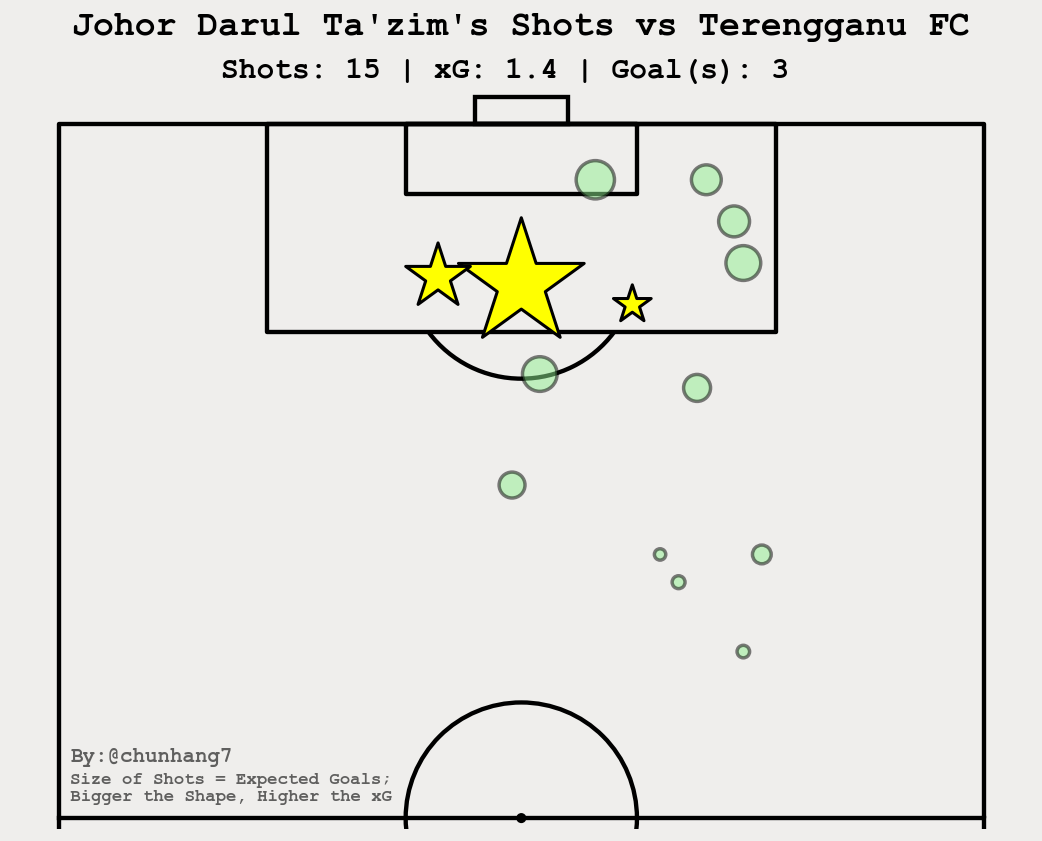

In [53]:
pitch = VerticalPitch(pad_bottom=0.9,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      pitch_type='statsbomb', 
                      pitch_color='#efeeec', 
                      line_color='black',
                      linewidth=2.5, 
                      spot_scale=0.003)

mpl.rcParams['figure.dpi'] = 125
fig, ax = pitch.draw(figsize=(9,7))
fig.set_facecolor('#efeeec')

plt.gca().invert_xaxis()

#plot the shot locations

#Goals
pitch.scatter(Goal.X, Goal.Y, s= Goal.xG, c='yellow', edgecolors='black', 
              zorder=3, linewidth = 1.75, marker='*', ax=ax, label = ' Goal')
#Shots on Target
pitch.scatter(Shot.X, Shot.Y, s= Shot.xG , c='lightgreen', edgecolors='black', alpha= 0.5,
              zorder=2, linewidth = 2, marker='o', ax=ax, label = ' Shot on Target')

plt.title(team+"'s Shots vs "+oppo+'\n',color='black',size=20, fontfamily = "Courier New", fontweight = "bold")

ax.text(66,124, 'Shots: ' + totalshots +' | xG: ' + totalxg +' | Goal(s): ' + goalsnum, fontsize=17, 
        color='black',fontweight = "bold",fontfamily = "Courier New")

#credits
fig.text(0.385,.07,'Size of Shots = Expected Goals;\n Bigger the Shape, Higher the xG', alpha=0.6,
         fontsize=10,fontfamily='Courier New',ha='right',color='black',fontweight='bold')
    
#credits
fig.text(.244,.115,'By:@chunhang7',fontsize=12,fontfamily='Courier New',alpha=0.6,
       ha='right',color='black',fontweight='bold')

plt.show()